# Lab 04: Extracting topics from research articles

# Part I: Data preprocessing

### Load dataset

- Source: https://www.kaggle.com/blessondensil294/topic-modeling-for-research-articles/version/1
- Download: https://georgetown.box.com/s/1qkrvdewe8ez35f2asblxysh136dvh6b

In [1]:
import pandas as pd

train_data = pd.read_csv('research-articles-dataset/train.csv').sample(frac=1)
test_data = pd.read_csv('research-articles-dataset/test.csv').sample(frac=1)

In [2]:
train_data

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
8914,8915,Searching edges in the overlap of two plane gr...,Consider a pair of plane straight-line graph...,1,0,0,0,0,0
13797,13798,Robust Recovery of Missing Data in Electricity...,The advanced operation of future electricity...,1,0,0,0,0,0
2187,2188,Simulating Cellular Communications in Vehicula...,The evolution of cellular technologies towar...,1,0,0,0,0,0
16260,16261,Weighted network estimation by the use of topo...,Topological metrics of graphs provide a natu...,1,0,0,0,0,0
20234,20235,Cluster-based Kriging Approximation Algorithms...,Kriging or Gaussian Process Regression is ap...,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
6542,6543,Local and global boundary rigidity and the geo...,In this paper we analyze the local and globa...,0,0,1,0,0,0
13918,13919,Computing the Lambert W function in arbitrary-...,We describe an algorithm to evaluate all the...,1,0,0,0,0,0
11074,11075,Quivers with additive labelings: classificatio...,We show that Zamolodchikov dynamics of a rec...,0,0,1,0,0,0
19124,19125,Energy Efficient Mobile Edge Computing in Dens...,"Merging Mobile Edge Computing (MEC), which i...",1,0,0,0,0,0


In [3]:
for topic in train_data.columns[3:]:
    print(f"{topic}: {sum(train_data[topic]) / len(train_data):.3f}")

Computer Science: 0.410
Physics: 0.287
Mathematics: 0.268
Statistics: 0.248
Quantitative Biology: 0.028
Quantitative Finance: 0.012


### Reuse Spacy pipeline from Lab-02 for text normalization & preprocessing

In [4]:
import re
import spacy
from spacy.language import Language

M = 2500

pipeline = spacy.load('en_core_web_sm')

# http://emailregex.com/
email_re = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""

# replace = [ (pattern-to-replace, replacement),  ...]
replace = [
    (r"<a[^>]*>(.*?)</a>", r"\1"),  # Matches most URLs
    (email_re, "email"),            # Matches emails
    (r"(?<=\d),(?=\d)", ""),        # Remove commas in numbers
    (r"\d+", "number"),              # Map digits to special token <numbr>
    (r"[\t\n\r\*\.\@\,\-\/]", " "), # Punctuation and other junk
    (r"\s+", " ")                   # Stips extra whitespace
]

train_sentences = []
for i, d in enumerate(train_data['ABSTRACT'][:M]):
    for repl in replace:
        d = re.sub(repl[0], repl[1], d)
    train_sentences.append(d)


@Language.component("lab04Preprocessor")
def ng20_preprocess(doc):
    tokens = [token for token in doc 
              if not any((token.is_stop, token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    tokens = [token for token in tokens if token]
    return " ".join(tokens)


pipeline.add_pipe("lab04Preprocessor")

<function __main__.ng20_preprocess(doc)>

### Pass data through our Spacy pipeline

In [5]:
docs = []
for sent in train_sentences[:M]:
    docs.append(pipeline(sent))

In [14]:
print(docs[0])

consider pair plane straight line graph edge color red blue respectively let n total complexity graph present o(n log n time o(n space technique preprocess pair graph enable efficient search red blue intersection edge graphs technique number application geometric problem include number solution batch red blue search problem dehne et al number o(n log n query oracle number algorithm compute maximum vertical distance pair numberd polyhedral terrain convex o(n log n time n total complexity terrain number algorithm construct hausdorff voronoi diagram family point cluster plane o((n+m log^number n time o(n+m space n total number point cluster m number crossing cluster number algorithm construct farth color voronoi diagram corner n axis align rectangle o(n log^number n time number algorithm solve stabbing circle problem n parallel line segment plane optimal o(n log n time result new improve well know algorithm


### Compute number of unique words (vocabulary size)

In [6]:
vocab_size = len(set(" ".join(docs).split(" ")))
vocab_size

16950

# Part 2: Build Features

### Build the term-document matrix (i.e., BOW features)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bow_featurizer = CountVectorizer(max_features=vocab_size, max_df=0.95, min_df=0.005, stop_words='english')
tfidf_featurizer = TfidfVectorizer(max_features=vocab_size, max_df=0.95, stop_words='english')
X_bow = bow_featurizer.fit_transform(docs)
X_tfidf = tfidf_featurizer.fit_transform(docs)
type(X_bow), X_bow.shape

(scipy.sparse.csr.csr_matrix, (2500, 1987))

### Create a index-to-word map

In [8]:
idx2word = {idx: word for word, idx in bow_featurizer.vocabulary_.items()}

### Number of topics hyperparameter

In [109]:
# Configurable
K = 10

### Plotting subroutine to visualize words

In [102]:
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

def plot_top_words(model, feature_names, n_top_words, title):
    plt.clf()
    cols = 5
    rows = K // 5 + K % 5
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[::-1][:n_top_words]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        if topic_idx >= len(axes):
            continue
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

### (10 pts) Task I: Build a LSA model

In this task we are going to build a LSA topic model from scratch. From lecture-04, we learned about LSA from the perspective of document retrieval. For document retrieval, you'll recall that we computed a truncated SVD by choosing some number of dimension $K << N$. This gave us the left singular column vectors, $\mathbf{V} \in \mathbb{R}^{N \times K}$, and the diagonal singular value matrix, $\boldsymbol{\Sigma} \in \mathbb{R}^{K \times K}$ that we needed in order to project our queries, $\mathbf{q} \in \mathbb{R}^{N}$, and documents, $\mathbf{d} \in \mathbb{R}^{N}$, into $\mathbb{R}^{K}$ space. Recall that the operation to do that was:

$$\hat{\mathbf{q}} = \mathbf{q}\mathbf{V}\mathbf{\Sigma}^{-1} $$

In this task, we're going to evaluate the singular values, $\sigma_{i,j}$ in $\mathbf{\Sigma}$, and their corresponding basis vectors, $\mathbf{u}^{(j)}$, in $\mathbf{U}$, to extract the principal themes in the data. Execute the following subtasks.

1. For each column vector, print out the top 10 most relevant words.
2. Visualize the top 10 words using the `plot_topics()` function provided above.
3. What affect does the hyperparameter $K$ have on the result?
4. Is there a principled way to determine an appropriate value for $K$?

In [21]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

In [55]:
# Your code goes here

bow_sums = np.asarray(X_bow.sum(axis=0)).flatten()
ind = np.argpartition(bow_sums, -10)[-10:]
ind

array([  62,  167, 1424, 1399, 1200, 1131, 1156, 1556, 1228,  442],
      dtype=int64)

In [58]:
top_words = [idx2word[i] for i in ind]
top_words

['algorithm',
 'base',
 'propose',
 'problem',
 'network',
 'method',
 'model',
 'result',
 'number',
 'datum']

In [59]:
n_topics = 6 # Based on topics given in train_data, seems like a good guess


In [65]:
X_t = X_bow.T # Now words are rows

In [77]:
X_bow

<2500x1987 sparse matrix of type '<class 'numpy.int64'>'
	with 123066 stored elements in Compressed Sparse Row format>

In [72]:
X_t

<1987x2500 sparse matrix of type '<class 'numpy.int64'>'
	with 123066 stored elements in Compressed Sparse Column format>

In [81]:
# Each element is the dot product between two terms
term_correlations = np.dot(X_t, X_bow)

In [82]:
# term_correlations = U * Sig * V.T
# https://stackoverflow.com/a/54339338 -- helped with understanding TruncatedSVD and how it relates to the equation above

In [87]:
svd = TruncatedSVD(100)

In [88]:
svd.fit(term_correlations)

TruncatedSVD(n_components=100)

In [89]:
embedding = svd.transform(term_correlations) # = U * Sigma

In [94]:
sigma = svd.singular_values_

In [93]:
V = svd.components_.T

In [95]:
U = embedding.dot(np.linalg.inv(np.diag(sigma)))

In [97]:
np.matmul(embedding, V.T).shape # Confirm that we got U, Sigma, and VT about right

(1987, 1987)

<Figure size 432x288 with 0 Axes>

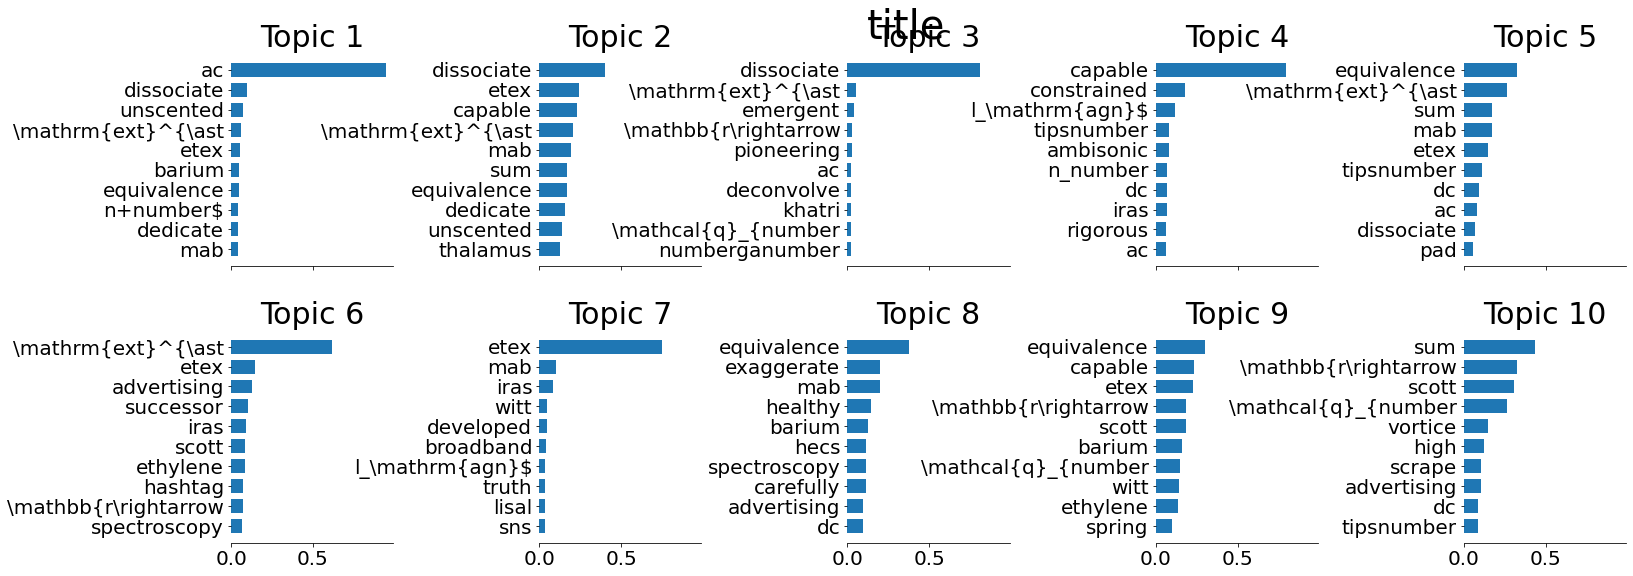

In [110]:
plot_top_words(svd, list(set(" ".join(docs).split(" "))), 10, 'title')

<Figure size 432x288 with 0 Axes>

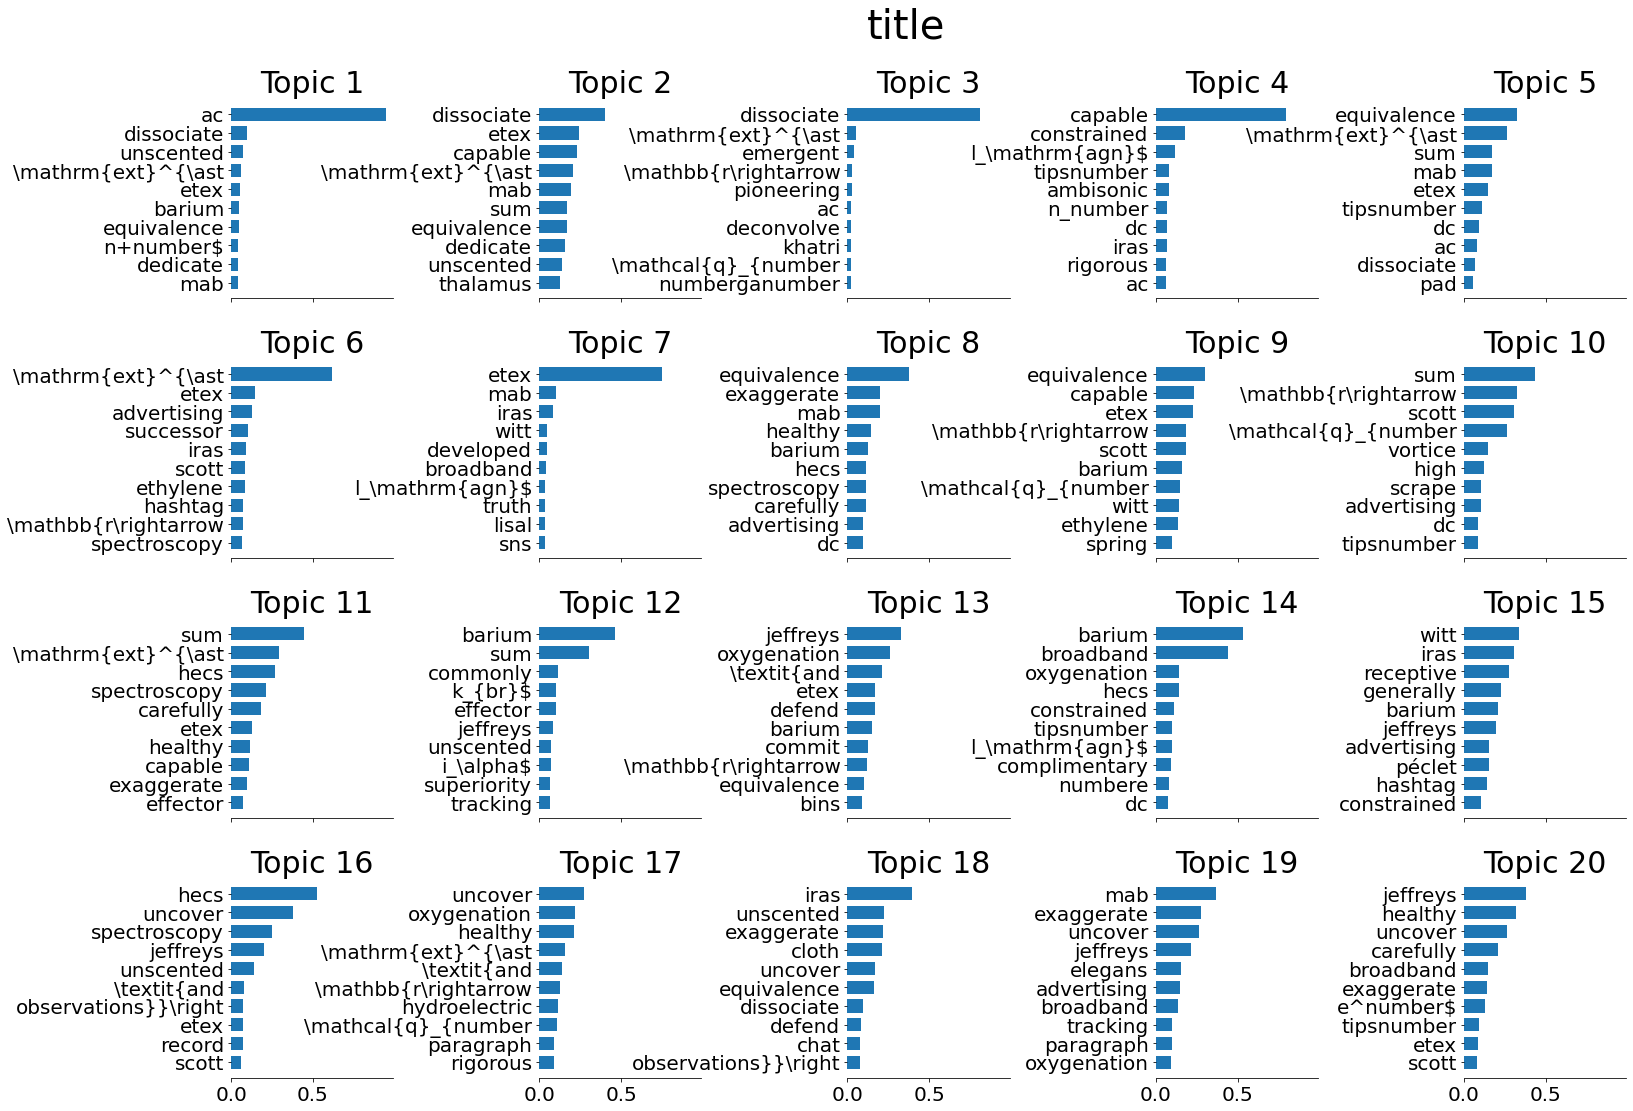

In [111]:
K = 20
plot_top_words(svd, list(set(" ".join(docs).split(" "))), 10, 'title')

In [ ]:
# It looks like K controls the number of topics shown!
# Yes, I've seen some formulae while researching help for this lab, 
#  but in my opinion they aren't as good as having a Subject Matter 
#  Expert in the room with you (for example here we could use our 
#  knowledge of the different topics provided to determine K)

### (5 pts) Task 2: Perform topic extraction using the NMF and LDA models from sklearn

In this task we perform topic extraction using the Non-negative Matrix Factorization (NMF) and Latent Dirichlet Allocation (LDA) models provided by sklearn. 

1. Fit the NMF and LDA models in the provided cells below.
2. Visualize the results using the `plot_topics` function.
3. How do the results compare to your home-spun LSA topic model?
4. What are the differences between these model that might give rise to these results?

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
# Your code goes here

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
# Your code goes here

### (5 pts) Task 3: Map the test data onto the topic spaces learned from the LSA, NMF, and LDA models

The purpose of this task is to assign topics to the test data

In [ ]:
# Your code goes here